In [1]:
!pip install keras==3.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [2]:
import keras
keras.__version__

'3.0.5'

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import os
import numpy as np

import tensorflow as tf
from PointNet import get_shape_segmentation_model as pointnet_seg
import keras

import matplotlib.pyplot as plt

In [6]:
os.chdir('/content/drive/MyDrive/DATA')

In [ ]:
clouds = []
labels = []
for folder in os.listdir():
    clouds_folder = './'+folder+'/velodyne'
    labels_folder = './'+folder+'/labels'
    clouds_names = os.listdir(clouds_folder)
    for cloud in clouds_names:
        clouds.append(np.fromfile(clouds_folder+'/'+cloud, np.float32).reshape(-1,5))
        labels.append(np.fromfile(labels_folder+'/'+cloud[:-3]+'label', np.int32))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clouds, labels)

c = np.array(list(map(lambda x: list(map(lambda y: list(x).count(y), range(3))), y_train)))

class_weights = {}
for i, j in enumerate(sum(np.mean(c, axis=0)) / np.mean(c, axis=0)):
  class_weights[i] = j

In [ ]:
class_weights

{0: 1.0075949615789315, 1: 168.07659830066655, 2: 629.7051999126065}

In [ ]:
from collections import Counter

def f(y):
  c = Counter(y)
  return [c[0], c[1], c[2]]

cc = np.array(list(map(f, y_train)))
cc[:, 0] = 2048 - cc[:, 1] + cc[:, 2]

class_weights = {}
for i, j in enumerate(sum(np.mean(cc, axis=0)) / np.mean(cc, axis=0)):
  class_weights[i] = j

class_weights

{0: 1.1210088480294544, 1: 11.7365041783542, 2: 43.971247542058116}

In [ ]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, data, labels, batch_size=32, shuffle=True, npoints=2048, class_weight=None):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        self.npoints = npoints
        self.nclasses = 3
        self.class_weight = class_weights
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data = list(map(lambda x: self.cut([self.data[x], self.labels[x]]), indexes))
        print(len(data), len(data[0]), data[0][0].shape)
        batch_data, batch_labels = [list(x) for x in zip(*data)]

        return np.array(batch_data), np.array(batch_labels)


    def cut(self, sample):

        points, labels = sample

        #cut road and background behind of the lidar
        x = points[:, 0].reshape(points.shape[0])
        y = points[:, 1].reshape(points.shape[0])

        condition = (y>-20)&(y<20)&(x>-5)&(x<40)

        points, labels = points[condition], labels[condition]

        #choose npoints number of points from cloud
        index = np.arange(len(points))

        return self.choose_points(points, labels)


    def choose_points(self, points, labels):
      N = len(labels)
      index = np.arange(N)
      new_index = np.array([])
      LABELS = list(set(labels))

      labels_transformed = np.zeros((N, self.nclasses))
      for i in LABELS:
        labels_transformed[labels == i, i] = 1

      if N >= self.npoints:
        for i in LABELS:
          if i != 0:
            new_index = np.append(new_index, index[labels == i])
        N0 = self.npoints - len(new_index)
        new_index = np.append(new_index, np.random.choice(index[labels == 0], N0))
      else:
        p = N / self.npoints
        for i in LABELS:
          j = index[labels == i]
          new_index = np.append(new_index, j)
          new_index = np.append(new_index, np.random.choice(j, int(p * len(j))+1), replace=True)
        new_index = np.random.choice(new_index, self.npoints)

      new_index = new_index.astype(np.int32)

      if self.class_weight:
        sw = self.get_sample_weights(labels[new_index])
        return points[new_index][:, :3], labels_transformed[new_index], sw

      return points[new_index][:, :3], labels_transformed[new_index]


    def get_sample_weights(self, labels):
      return np.array(list(map(lambda y: class_weights.get(int(y), 1.0), labels)))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, data, labels, batch_size=32, shuffle=True, npoints=2048, class_weight=None):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        self.npoints = npoints
        self.nclasses = 3
        self.class_weight = class_weights
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data = list(map(lambda x: self.cut([self.data[x], self.labels[x]]), indexes))

        if self.class_weight:
          batch_data, batch_labels, batsh_sample_weights = [list(x) for x in zip(*data)]
          return np.array(batch_data), np.array(batch_labels), np.array(batsh_sample_weights)

        batch_data, batch_labels = [list(x) for x in zip(*data)]
        return np.array(batch_data), np.array(batch_labels)

    def cut(self, sample):

        points, labels = sample

        #cut road and background behind of the lidar
        x = points[:, 0].reshape(points.shape[0])
        y = points[:, 1].reshape(points.shape[0])

        condition = (y>-20)&(y<20)&(x>-5)&(x<40)

        points, labels = points[condition], labels[condition]

        #choose npoints number of points from cloud
        index = np.arange(len(points))

        return self.choose_points(points, labels)


    def choose_points(self, points, labels):
      N = len(labels)
      index = np.arange(N)
      new_index = np.array([])
      LABELS = list(set(labels))

      labels_transformed = np.zeros((N, self.nclasses))
      for i in LABELS:
        labels_transformed[labels == i, i] = 1

      if N >= self.npoints:
        for i in LABELS:
          if i != 0:
            new_index = np.append(new_index, index[labels == i])
        N0 = self.npoints - len(new_index)
        new_index = np.append(new_index, np.random.choice(index[labels == 0], N0))
      else:
        p = N / self.npoints
        for i in LABELS:
          j = index[labels == i]
          new_index = np.append(new_index, j)
          new_index = np.append(new_index, np.random.choice(j, int(p * len(j))+1), replace=True)
        new_index = np.random.choice(new_index, self.npoints)

      new_index = new_index.astype(np.int32)

      if self.class_weight:
        sw = self.get_sample_weights(labels[new_index])
        return points[new_index][:, :3], labels_transformed[new_index], sw

      return points[new_index][:, :3], labels_transformed[new_index]


    def get_sample_weights(self, labels):
      return np.array(list(map(lambda y: class_weights.get(int(y), 1.0), labels)))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
dg = DataGenerator(X_train, y_train, npoints=2048, class_weight=class_weights)
dg_val = DataGenerator(X_test, y_test, npoints=2048, class_weight=class_weights)

In [ ]:
dg = DataGenerator(X_train, y_train, npoints=2048)
dg_val = DataGenerator(X_test, y_test, npoints=2048)

In [ ]:
dg.__getitem__(0)

32 3 (2048, 3)


ValueError: too many values to unpack (expected 2)

In [ ]:
num_points = 2048
num_classes = 3

segmentation_model = pointnet_seg(num_points, num_classes)
segmentation_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 3)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │            256 │ input_layer[0][0]      │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │            256 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │          8,320 │ input_transformation_… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │            512 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │        132,096 │ input_transformation_… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │          4,096 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 1024)           │              0 │ input_transformation_… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │        524,800 │ global_max_pooling1d[… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │          2,048 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_

 Total params: 7,369,804 (28.11 MB)

 Trainable params: 7,355,852 (28.06 MB)

 Non-trainable params: 13,952 (54.50 KB)

Steps per epoch: 29.
Total training steps: 725.


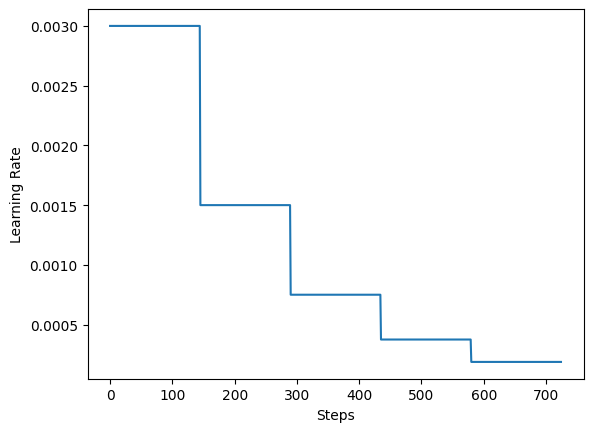

In [ ]:
total_training_examples = len(X_train)
BATCH_SIZE = 32
EPOCHS = 25

steps_per_epoch = total_training_examples // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
def run_experiment(epochs):
    segmentation_model = pointnet_seg(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/content/drive/MyDrive/checkpoint2.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        dg,
        validation_data=dg_val,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 522ms/step - accuracy: 0.5782 - loss: 5129.6587 - val_accuracy: 0.0910 - val_loss: 68173640.0000
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 543ms/step - accuracy: 0.7001 - loss: 242.3385 - val_accuracy: 0.7334 - val_loss: 42747.8477
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.7819 - loss: 157.2703 - val_accuracy: 0.8767 - val_loss: 576.3376
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 502ms/step - accuracy: 0.8033 - loss: 150.6391 - val_accuracy: 0.8941 - val_loss: 172.7727
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 517ms/step - accuracy: 0.7953 - loss: 142.8791 - val_accuracy: 0.8892 - val_loss: 163.2797
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.8084 - loss: 139.8081 - val_accuracy: 0.9035 - val_loss: 160.2002
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 495ms/step - accuracy: 0.8284 - loss: 138.3863 - val_accuracy: 0.8882 - val_loss: 156.4267
Epoch 8/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 508ms/step - accura

In [ ]:
validation_batch = next(iter(dg_val))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Validation prediction shape: (32, 2048, 3)


In [ ]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
validation_batch[1][0].shape

(100, 3)

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(validation_batch[0][0])
pcd.colors = o3d.utility.Vector3dVector(validation_batch[1][0])
o3d.visualization.draw_plotly([pcd])

In [ ]:
np.round(val_predictions[0])

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(validation_batch[0][0])
pcd.colors = o3d.utility.Vector3dVector(np.round(val_predictions[0]))
o3d.visualization.draw_plotly([pcd])

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
9.5/0.5

19.0

In [ ]:
omega_in = (class_weights[1] * class_weights[2] / (class_weights[1] + class_weights[2]))
omega_out = class_weights[0]

def energy_loss(y_true, y_pred, omega_in=omega_in, omega_out=omega_out, min_value=0.0, max_value=2.0, l=10e-7):

    # Расчет ошибки сегментации
    seg_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)

    #Рассчет энергии
    y_true = tf.cast(tf.argmax(y_true, axis=-1), dtype=tf.float32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), dtype=tf.float32)

    inlier_mask = tf.cast(tf.equal(y_true, 0), dtype=tf.float32)
    outlier_mask = tf.cast(tf.where(tf.logical_or(tf.equal(y_true, 1), tf.equal(y_true, 2)), 1, 0), dtype=tf.float32)

    energy_diff = y_pred - 0
    hinge_in = tf.square(tf.maximum(0.0, energy_diff)) * omega_in

    energy_diff = 2 - y_pred
    hinge_out = tf.square(tf.maximum(0.0, energy_diff)) * omega_out
    #tf.print(l * tf.reduce_sum(hinge_in * inlier_mask + hinge_out * outlier_mask))
    #tf.print(seg_loss)


    loss = l * tf.reduce_sum(hinge_in * inlier_mask + hinge_out * outlier_mask) + seg_loss
    return loss

In [ ]:
energy_loss(validation_batch[1], val_predictions)

0.134088814
0.244992569


<tf.Tensor: shape=(), dtype=float32, numpy=0.37908137>

In [ ]:
def run_experiment(epochs):
    segmentation_model = pointnet_seg(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=energy_loss,
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/content/drive/MyDrive/checkpoint2.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        dg,
        validation_data=dg_val,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 535ms/step - accuracy: 0.6677 - loss: 18031.0371 - val_accuracy: 0.8934 - val_loss: 309186.8438
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 560ms/step - accuracy: 0.8955 - loss: 340.3681 - val_accuracy: 0.8934 - val_loss: 264.9474
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step - accuracy: 0.8986 - loss: 185.6637 - val_accuracy: 0.8944 - val_loss: 184.6710
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.9064 - loss: 168.0816 - val_accuracy: 0.8941 - val_loss: 176.6703
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9121 - loss: 159.1087 - val_accuracy: 0.8935 - val_loss: 248.1918
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.9218 - loss: 153.5268 - val_accuracy: 0.8937 - val_loss: 309.1225
Epoch 7/25
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9251 - loss: 150.7828